# NeRF: an Efficient Implementation
### Xiyue Wang (UNI: xw2957)
### COMS 4732, Spring 2024, Columbia University

This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)


In [1]:
import os, sys
import tensorflow as tf
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

2024-04-21 20:25:25.605170: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 20:25:25.605284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 20:25:25.776659: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!wget --no-check-certificate http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip

--2024-04-21 20:25:38--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip [following]
--2024-04-21 20:25:38--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 370385516 (353M) [application/zip]
Saving to: 'nerf_example_data.zip'

nerf_example_data.z  32%[=====>              ] 113.32M  4.49MB/s    eta 54s    ^C


In [3]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget --no-check-certificate http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2024-04-21 20:26:05--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-04-21 20:26:05--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: 'tiny_nerf_data.npz'

tiny_nerf_data.npz  100%[===================>]  12.14M  20.7MB/s    in 0.6s    

2024-04-21 20:26:06 (20.7 MB/s) - 'tiny_nerf_data.npz' saved [12727482/12727482]



# Load Input Images and Poses

Images shape: (100, 100, 100, 3), Poses shape: (100, 4, 4), Focal length: 138.88887889922103


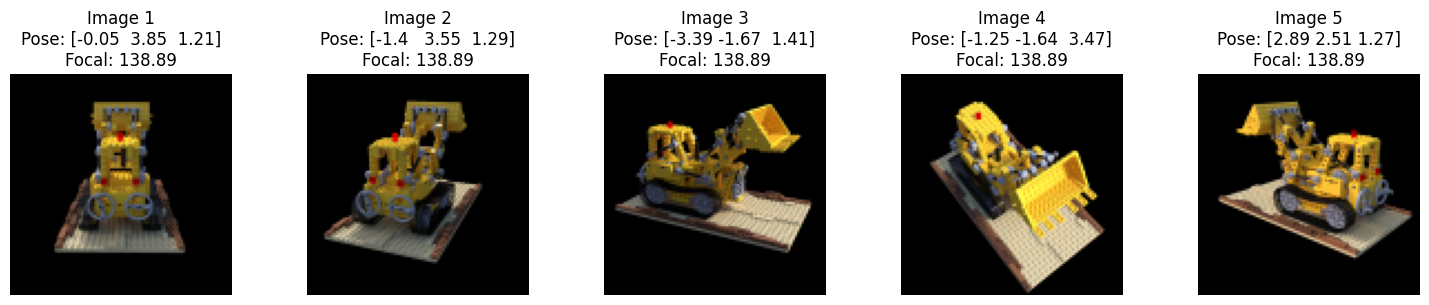

In [9]:
# Load data from the NeRF dataset
data = np.load('tiny_nerf_data.npz')
images = data['images']  # Images array
poses = data['poses']    # Camera poses array
focal = data['focal']    # Focal length
H, W = images.shape[1:3]  # Image dimensions

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

# Print dataset information
print(f"Images shape: {images.shape}, Poses shape: {poses.shape}, Focal length: {focal}")

# Define number of images to visualize
num_images_to_visualize = 5  # Adjust this number based on how many images you want to show

# Create a figure with subplots
fig, axes = plt.subplots(1, num_images_to_visualize, figsize=(15, 3))  # Adjust figure size to your liking

# Iterate through the first few images in the dataset
for i, ax in enumerate(axes):
    img = images[i]
    pose = poses[i]
    # Display the image
    ax.imshow(img)
    # Set the title with pose information (displaying the translation part of the pose)
    ax.set_title(f'Image {i+1}\nPose: {pose[:3, 3].round(2)}\nFocal: {focal:.2f}')
    ax.axis('off')  # Hide axes ticks

# Display the plot
plt.tight_layout()
plt.show()

# Optimize NeRF

In [10]:
# Define positional encoding function
def positional_encoding(x, L_embed=6):
    rets = [x]
    for i in range(L_embed):
        for fn in [tf.sin, tf.cos]:
            rets.append(fn(2.**i * x))
    return tf.concat(rets, -1)

def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d


def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3])

    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1.-tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow will run on GPU.")
else:
    print("TensorFlow could not find the GPU. Make sure the installation and GPU setup are correct.")

Num GPUs Available:  2
TensorFlow will run on GPU.


In [12]:
L_embed = 6
embed_fn = positional_encoding
# L_embed = 0
# embed_fn = tf.identity

def init_MLP_model(D=8, W=256, L_embed=6):
    input_dim = 3 + 3 * 2 * L_embed
    inputs = tf.keras.Input(shape=(input_dim,))
    x = inputs
    for i in range(D):
        x = tf.keras.layers.Dense(W, activation='relu')(x)
        if i % 4 == 0 and i > 0:
            x = tf.keras.layers.Concatenate(axis=-1)([x, inputs])
    outputs = tf.keras.layers.Dense(4, activation=None)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

Iteration 0, Time per Iteration: 0.0108 seconds


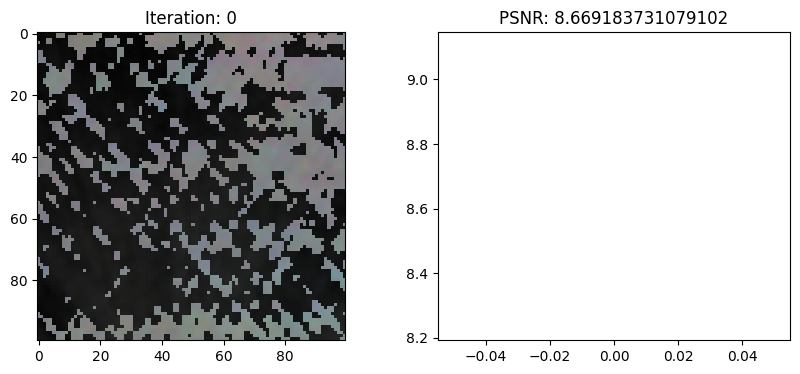

Iteration 50, Time per Iteration: 0.7312 seconds


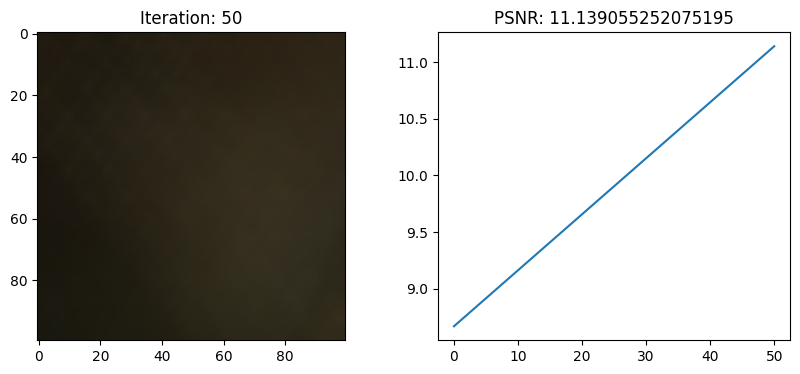

Iteration 100, Time per Iteration: 0.7251 seconds


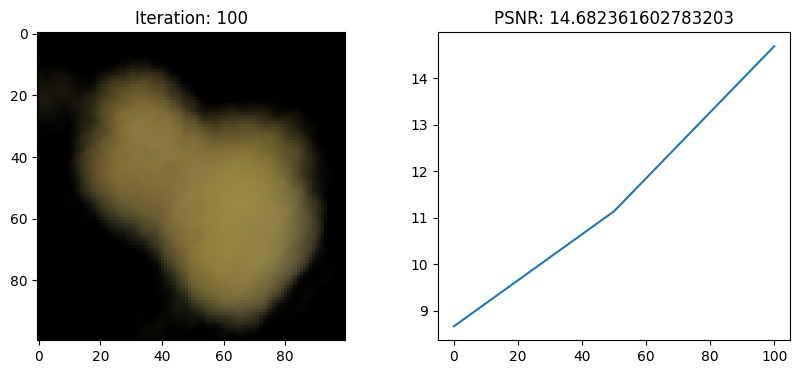

Iteration 150, Time per Iteration: 0.6971 seconds


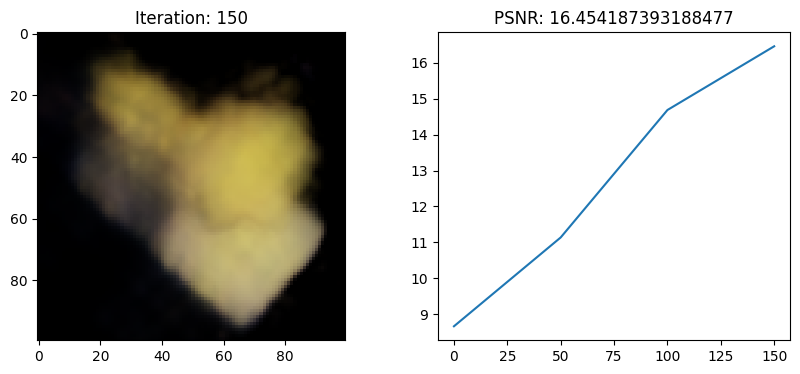

Iteration 200, Time per Iteration: 0.6986 seconds


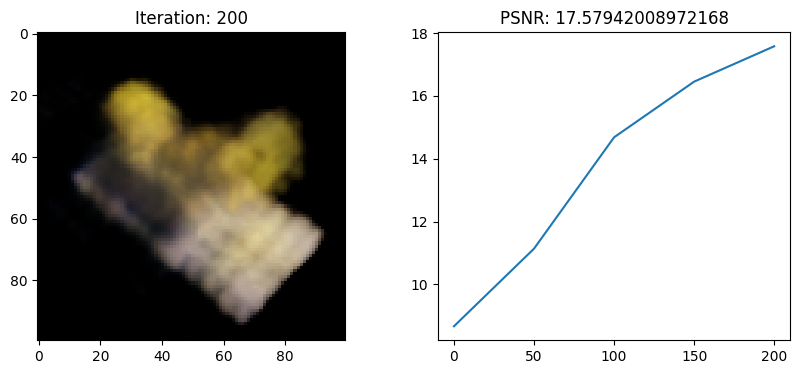

Iteration 250, Time per Iteration: 0.6988 seconds


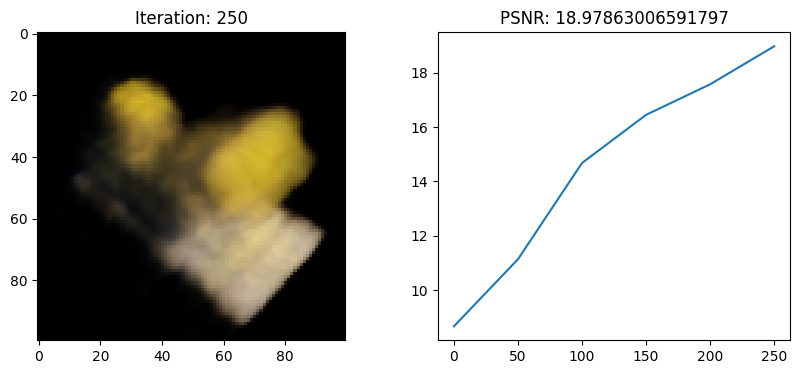

Iteration 300, Time per Iteration: 0.7001 seconds


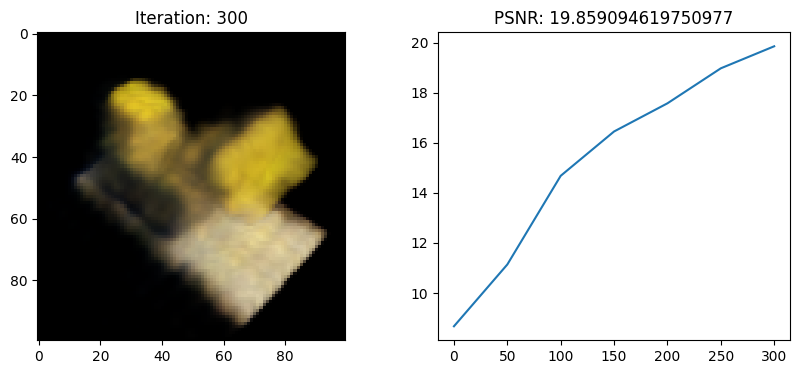

Iteration 350, Time per Iteration: 0.7037 seconds


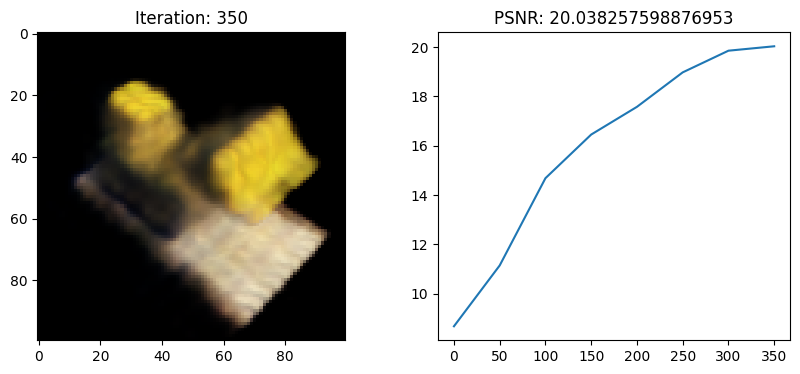

Iteration 400, Time per Iteration: 0.7019 seconds


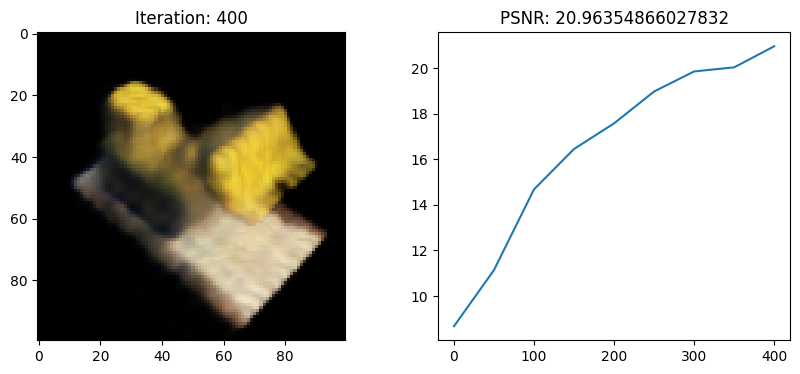

Iteration 450, Time per Iteration: 0.7013 seconds


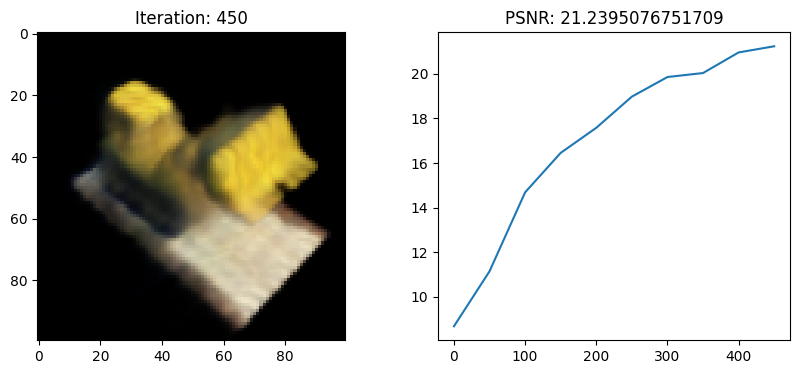

Iteration 500, Time per Iteration: 0.7043 seconds


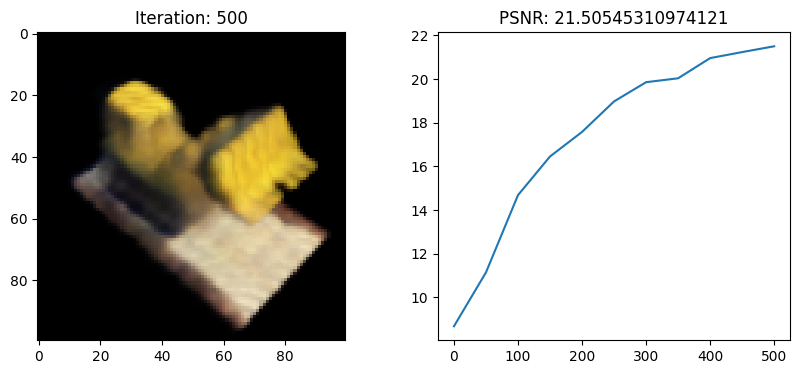

Iteration 550, Time per Iteration: 0.7059 seconds


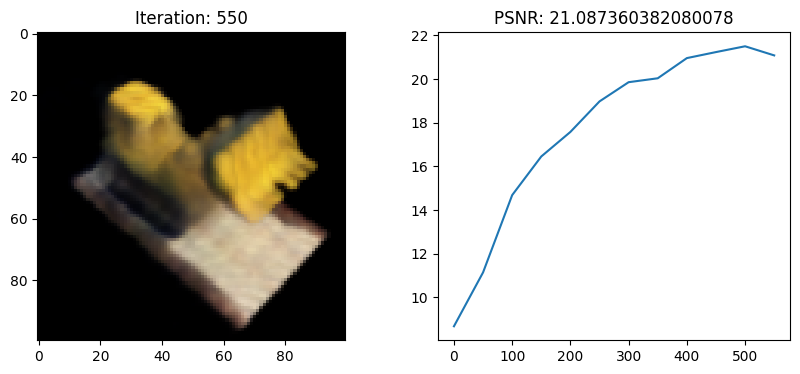

Iteration 600, Time per Iteration: 0.6985 seconds


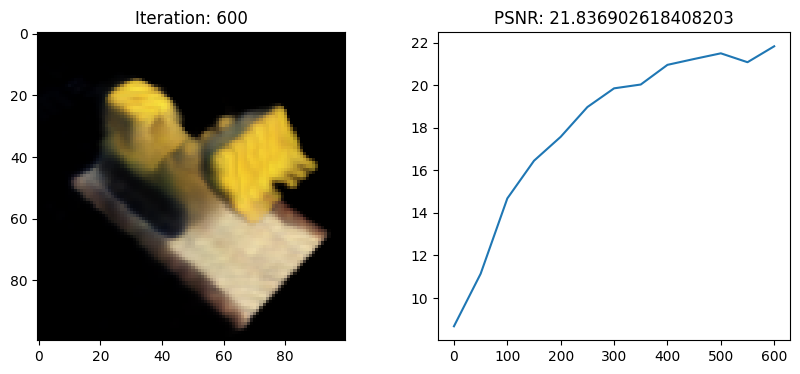

Iteration 650, Time per Iteration: 0.6980 seconds


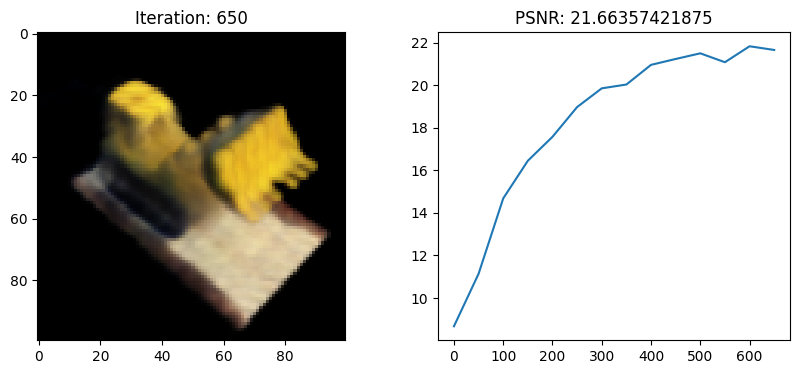

Iteration 700, Time per Iteration: 0.7042 seconds


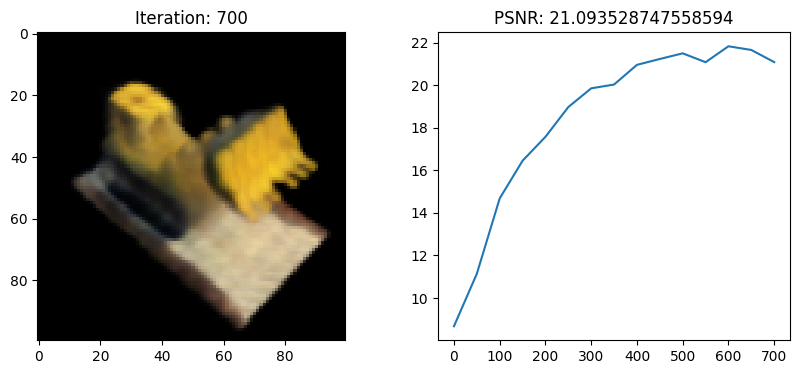

Iteration 750, Time per Iteration: 0.6991 seconds


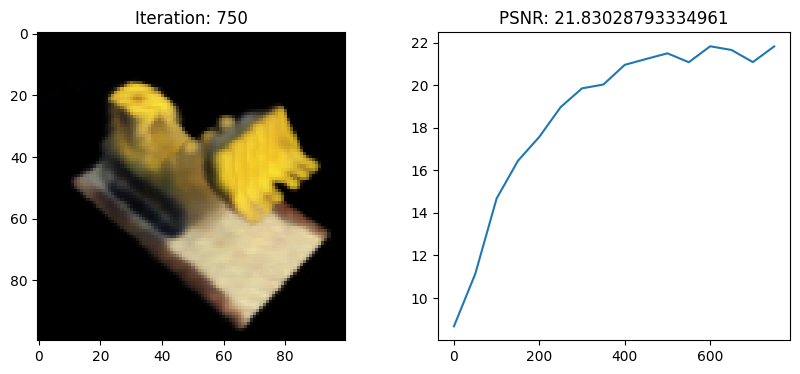

Iteration 800, Time per Iteration: 0.6981 seconds


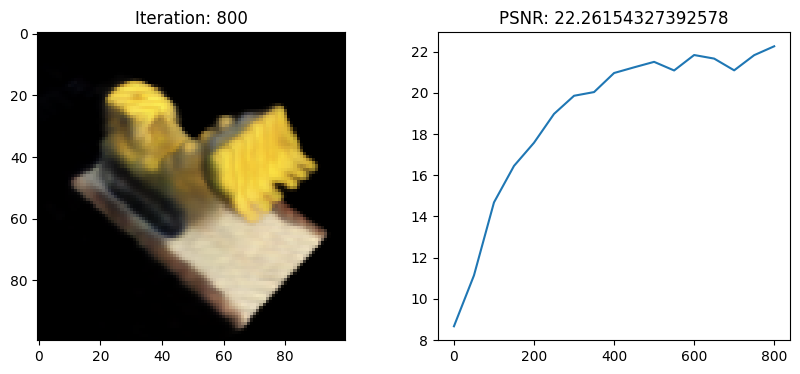

Iteration 850, Time per Iteration: 0.6997 seconds


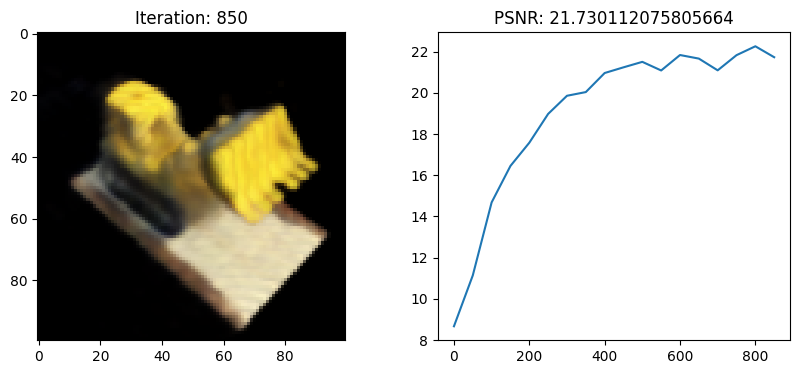

Iteration 900, Time per Iteration: 0.6983 seconds


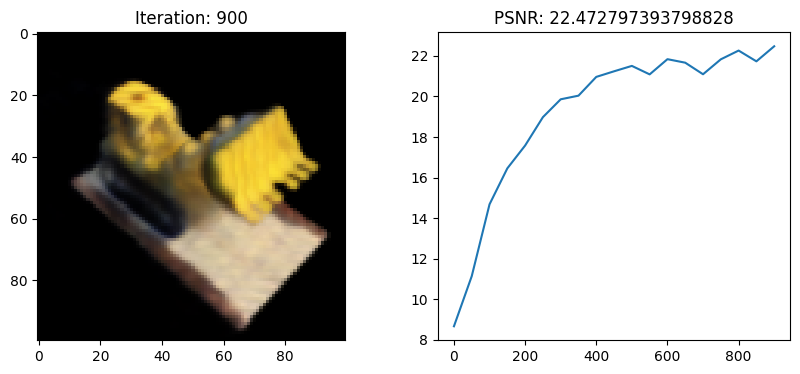

Iteration 950, Time per Iteration: 0.6971 seconds


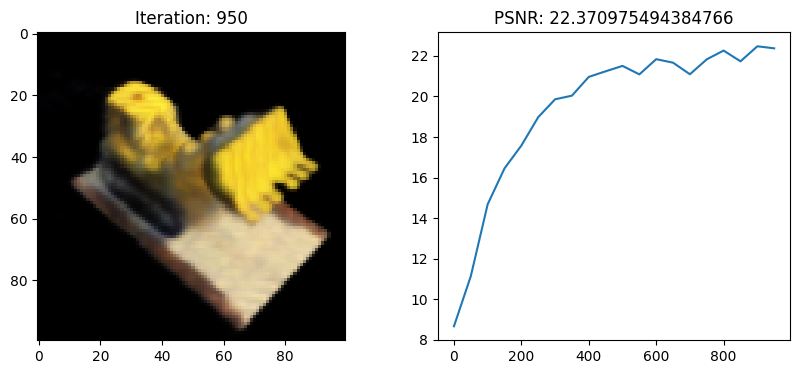

Iteration 1000, Time per Iteration: 0.7019 seconds


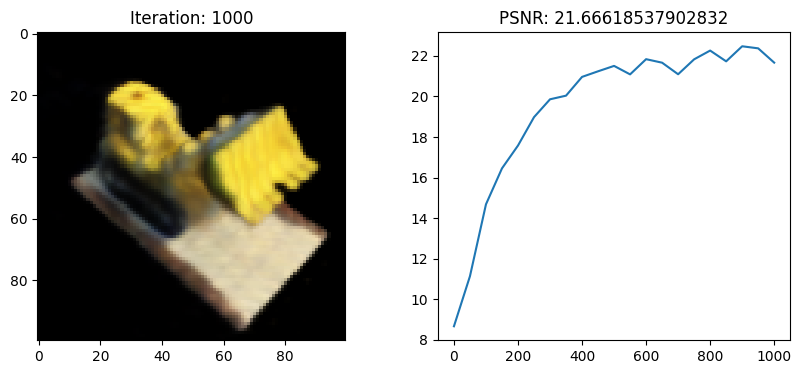

Done


In [14]:
model = init_MLP_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 50

import time
t = time.time()
for i in range(N_iters+1):

    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if i%i_plot==0:
        print(f'Iteration {i}, Time per Iteration: {(time.time() - t) / i_plot:.4f} seconds')
        t = time.time()

        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title(f'PSNR: {psnr}')
        plt.show()

print('Done')

# Interactive Visualization

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

# Render 360 Video

In [ ]:
!pip install imageio[ffmpeg]

In [ ]:
import imageio

frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

# Ensure that the file extension is .mp4
f = 'video.mp4'

# Use 'FFMPEG' format writer, which is suitable for .mp4 video files
imageio.mimwrite(f, frames, fps=30, quality=7, format='FFMPEG')

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)